<a href="https://colab.research.google.com/github/CGnal/agos-ai-course/blob/master/day3/3_2_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow-gpu==2.6.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np 
import pandas as pd 


In [ ]:
%load_ext tensorboard
import tensorboard
tensorboard.__version__

'2.7.0'

In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-uwlz2rzv
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-uwlz2rzv


## Generate dataset 

In [ ]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1 0.5*sin(t-off1)*10(freq1+1)
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2 0.2*sin(t-off2)*20(freq2+1)
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise 
    return series[..., np.newaxis].astype(np.float32)


def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "gx", markersize=12)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# batch_size, timesteps, features

((7000, 50, 1), (7000, 1), (1000, 50, 1), (1000, 1))

### Description

1. 10000 samples
2. each sample is 50 timesteps long i.e. t1....t50
3. label for each sample is t51 i.e. y_valid
4. shape : batch_size, timesteps, features 
5. single sample 
```python
X_valid[0].shape, y_valid[0].shape
#((50, 1), (1,))
```


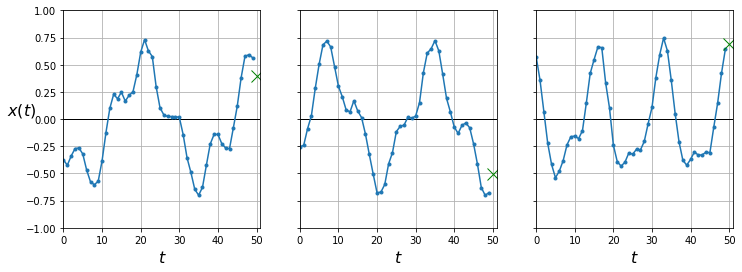

In [ ]:
# first three samples 


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
#save_fig("time_series_plot")
plt.show()

### Computing Some Baselines
Do some naive predictions: just predict the last observed value 

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

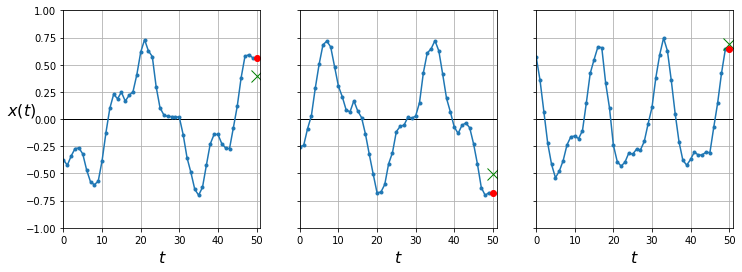

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_pred[col, 0],
                y_label=("$x(t)$" if col==0 else None))
#save_fig("time_series_plot")
plt.show()

## Linear model

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_linear = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
], name='linear')

model_linear.compile(loss="mse", optimizer="adam")
history = model_linear.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [ ]:
model_linear.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168087616562843

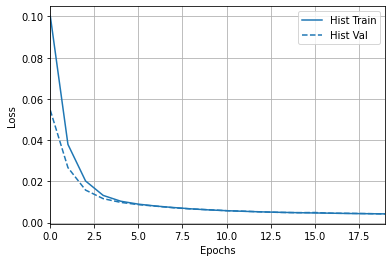

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=0)
plotter.plot({'hist':history})

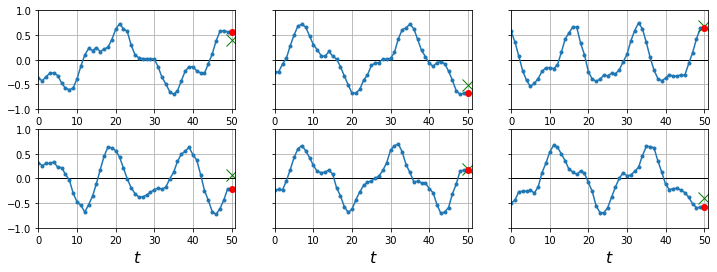

In [ ]:
ypred = model_linear.predict(X_valid)
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 4))

for idx, (r,c) in enumerate([(r,c) for r in range(2) for c in range(3)]):
    plt.sca(axes[r,c])
    plot_series(X_valid[idx, :, 0], y_valid[idx, 0], y_pred[idx, 0],
                y_label=("$x(t)$" if col==0 else None))
#save_fig("time_series_plot")
plt.show()

## Input data shapes for RNNs

![picture](https://drive.google.com/uc?id=1mFRjBhlRAdc53LzBfhs9ollaVFBvki-A)




## Many to one univariate prediction (single feature single timestep)


1. timesteps :`t1.....t50`
2. predict:`t51`
3. Input dataset shape : **batch_size, timesteps, features**
4. Output shape : **batch_size, 1, features**
5. `RNN(units=1, input_shape=(timesteps, 1))`


```python

# simple rnn 
model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[50, 1])
])

# deeper rnn 
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(8, return_sequences=True, input_shape=[50, 1]),
    keras.layers.Dense(1)
])

```

### Simple RNN



In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


# input shape = [batch_size, timesteps, nfeatures]
# we can also leave timestep as None, keras will understand by looking at the input data
# in keras we write as = [timesteps, nfeatures] = [50,1]
# output shape = [batch_size, last_timestep, nfeatures]


model_simple_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[50, 1]) #or [None,1]
], name='simple_rnn')

plot_model(model_simple_rnn, show_shapes=True)

y = model_simple_rnn.predict(X_train[:10, :,:])

print("input_dataset_shape:", X_train[:10,:,:].shape) #batch_size, 
print("output_dataset_shape:", y.shape) #batchsize,1 timestep



input_dataset_shape: (10, 50, 1)
output_dataset_shape: (10, 1)


In [ ]:

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model_simple_rnn.compile(loss="mse", optimizer=optimizer)
history = model_simple_rnn.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))



Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0116 - val_loss: 0.011

In [ ]:
model_simple_rnn.evaluate(X_valid, y_valid)


63/63 [==============================] - 0s 4ms/step - loss: 0.0109


0.010881561785936356

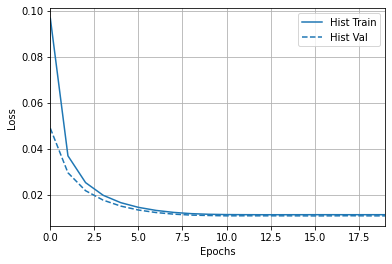

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=0)
plotter.plot({'hist':history})

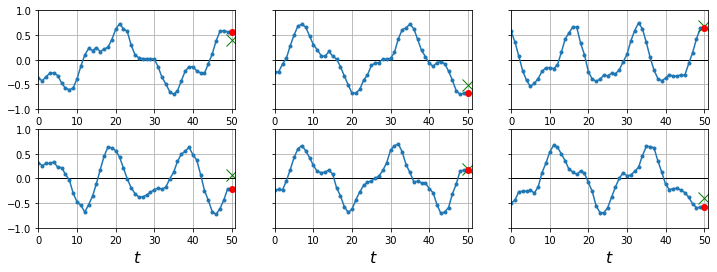

In [ ]:
ypred = model_simple_rnn.predict(X_valid)
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 4))

for idx, (r,c) in enumerate([(r,c) for r in range(2) for c in range(3)]):
    plt.sca(axes[r,c])
    plot_series(X_valid[idx, :, 0], y_valid[idx, 0], y_pred[idx, 0],
                y_label=("$x(t)$" if col==0 else None))
#save_fig("time_series_plot")
plt.show()

### Deep RNNs
We stack multiple RNN layers on top of each other. 

We make each layer return data of the type many to many.


![picture](https://drive.google.com/uc?id=1AUxmng4gkmbRe16tagTZwgexuwTOSH2u)





#### Return sequences = False

![picture](https://drive.google.com/uc?id=1tqE3gvKS7Bpsp5zSbbEU09IRKvkeAil2)

#### Return sequences = True

![picture](https://drive.google.com/uc?id=1pfM4wd5t2_XqY6uPVcSG9CR_RtE2P_hh)



In [ ]:
# behaviour of return sequences = True 

model = keras.models.Sequential([
    keras.layers.SimpleRNN(8, return_sequences=True, input_shape=[50, 1]),
])

plot_model(model, show_shapes=True)

y = model.predict(X_train[:10, :,:])

print("input_dataset_shape:", X_train[:10,:,:].shape) #batch_size, timestep, features
print("output_dataset_shape:", y.shape) #batchsize,timestep, rnn_units


input_dataset_shape: (10, 50, 1)
output_dataset_shape: (10, 50, 8)


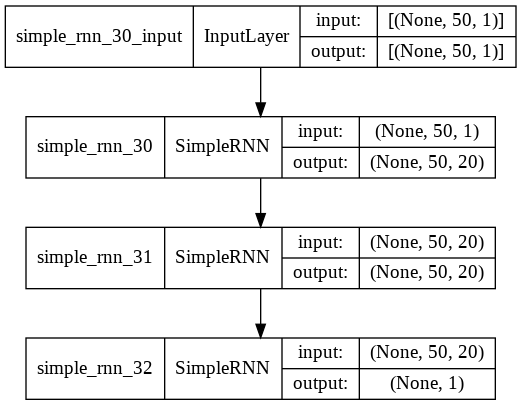

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
], name='deep_rnn')



plot_model(model_deep_rnn, show_shapes=True)


In [ ]:
y = model_deep_rnn.predict(X_train[:10, :,:])
print("input_dataset_shape:", X_train[:10,:,:].shape) #batch_size, timestep, features
print("output_dataset_shape:", y.shape) #batchsize,1



input_dataset_shape: (10, 50, 1)
output_dataset_shape: (10, 1)


In [ ]:
model_deep_rnn.compile(loss="mse", optimizer="adam")
history = model_deep_rnn.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 11s 35ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0035 - val_l

In [ ]:
model_deep_rnn.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0029


0.002910564886406064

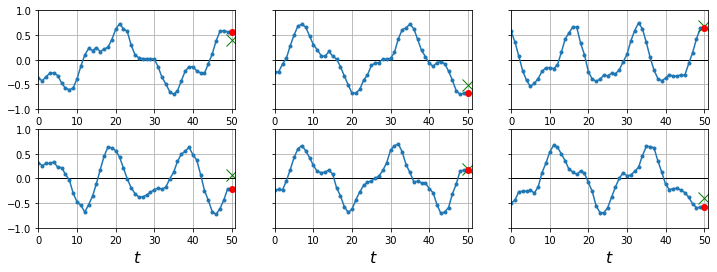

In [ ]:
ypred = model_deep_rnn.predict(X_valid)
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 4))

for idx, (r,c) in enumerate([(r,c) for r in range(2) for c in range(3)]):
    plt.sca(axes[r,c])
    plot_series(X_valid[idx, :, 0], y_valid[idx, 0], y_pred[idx, 0],
                y_label=("$x(t)$" if col==0 else None))
#save_fig("time_series_plot")
plt.show()

### Deep RNN + Dense(1)

Note:

keras from version 2.0 Dense is by default applied to only last dimension (e.g. if you apply Dense(10) to input with shape (n, m, o, p) you'll get output with shape (n, m, o, 10))



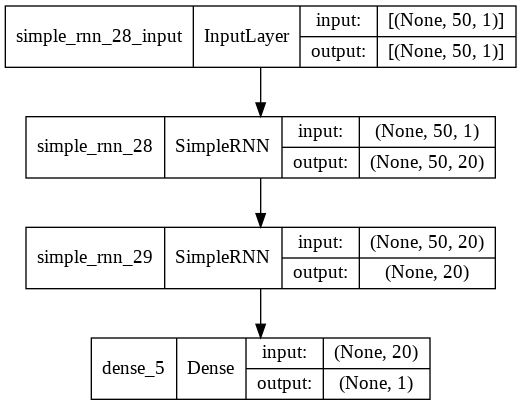

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_deep_rnn_dense = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[50, 1]),
    keras.layers.SimpleRNN(20), # this rnn warms up until it makes a single prediction
    keras.layers.Dense(1)
], name='deep_rnn_dense')


plot_model(model_deep_rnn_dense, show_shapes=True)


In [ ]:
model_deep_rnn_dense.compile(loss="mse", optimizer="adam")
history = model_deep_rnn_dense.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 22ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0030 - val_lo

In [ ]:
model_deep_rnn_dense.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


0.002623623237013817

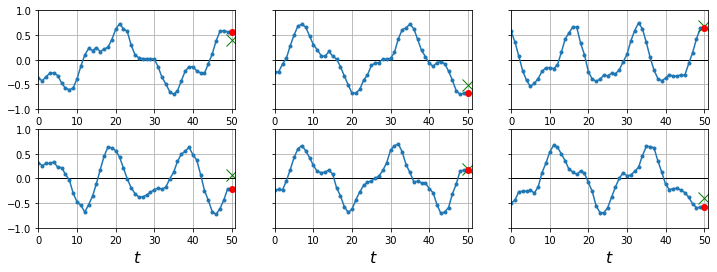

In [ ]:
ypred = model_deep_rnn_dense.predict(X_valid)
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 4))

for idx, (r,c) in enumerate([(r,c) for r in range(2) for c in range(3)]):
    plt.sca(axes[r,c])
    plot_series(X_valid[idx, :, 0], y_valid[idx, 0], y_pred[idx, 0],
                y_label=("$x(t)$" if col==0 else None))
#save_fig("time_series_plot")
plt.show()

## Compare model performances 


In [ ]:
all_models = [model_linear, model_simple_rnn, model_deep_rnn, model_deep_rnn_dense]
losses = {mm.name:mm.evaluate(X_valid, y_valid) for mm in all_models}

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


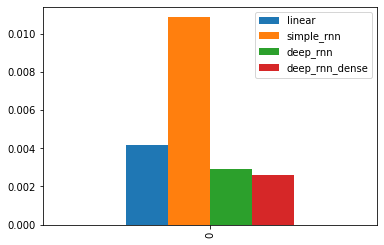

In [ ]:
pd.DataFrame(losses, index=[0]).plot(kind='bar')

## Many to many univariate prediction (single feature multiple timesteps)


1. timesteps :`t1.....t50`
2. predict:10 timesteps that is `t51....t61`
3. Input dataset shape : **batch_size, timesteps, features**
4. Output shape : **batch_size, 1, features**
5. `RNN(units=1, input_shape=(timesteps, 1))`


```python

# simple rnn 
model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[50, 1])
    keras.layers.Dense(nsteps)
])

# deep rnn  
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(8, input_shape=[50, 1]),
    keras.layers.Dense(nsteps)
])


# deeper rnn 
model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(8, return_sequences=True, input_shape=[50, 1]),
    keras.layers.SimpleRNN(8, return_sequences=False, input_shape=[50, 1]),
    keras.layers.Dense(nsteps)
])
```

### Dataset 


In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


In [ ]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
#X_train : batch_size, timesteps, nfeatures 
#Y_train : batch_size, timesteps = 7000, 10 timesteps
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_valid.shape, Y_valid.shape


((7000, 50, 1),
 (7000, 10),
 (1000, 50, 1),
 (1000, 10),
 (2000, 50, 1),
 (2000, 10))

### Simple RNN + Dense


![picture](https://drive.google.com/uc?id=1vXW_EZWcetlA4dVNlcraIhfJS_YwMX2i)


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_deep_rnn_dense = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
], name='deep_rnn_dense_many')

model_deep_rnn_dense.compile(loss="mse", optimizer="adam")
history = model_deep_rnn_dense.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 23ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0110 - val_lo

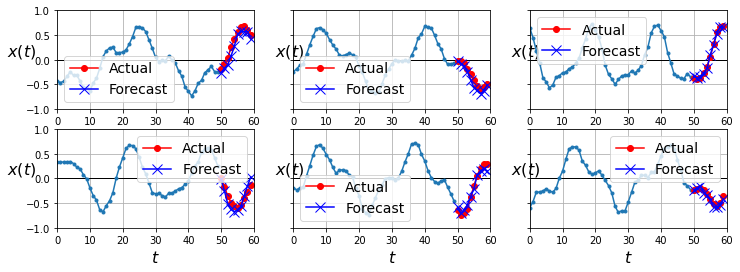

In [ ]:
ypred = model_deep_rnn_dense.predict(X_valid)


fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 4))

for idx, (r,c) in enumerate([(r,c) for r in range(2) for c in range(3)]):
    plt.sca(axes[r,c])
    plot_multiple_forecasts(np.expand_dims(X_valid[idx], 0), 
                            np.expand_dims(Y_valid[idx, None], -1),
                            np.expand_dims(ypred[idx, None], -1))
plt.show()

### Simple LSTM + Dense

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_lstm_dense = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(10)
    #keras.layers.TimeDistributed(keras.layers.Dense(10))
], name='lstm_dense')

model_lstm_dense.compile(loss="mse", optimizer="adam")
history = model_lstm_dense.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 17s 58ms/step - loss: 0.0629 - val_loss: 0.0396
Epoch 2/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0327 - val_loss: 0.0257
Epoch 3/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0223 - val_loss: 0.0205
Epoch 4/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0195 - val_loss: 0.0201
Epoch 5/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0179 - val_loss: 0.0170
Epoch 6/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0163 - val_loss: 0.0162
Epoch 7/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0157 - val_loss: 0.0150
Epoch 8/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 9/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 10/20
219/219 [==============================] - 11s 52ms/step - loss: 0.013

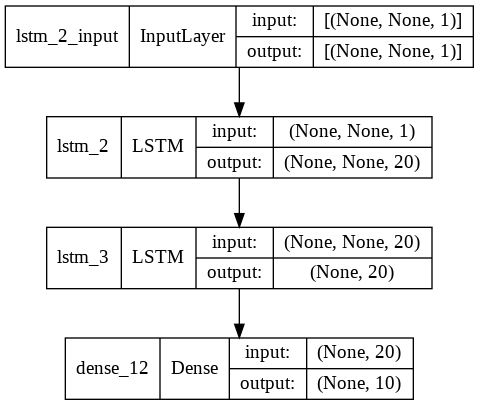

In [ ]:
plot_model(model_lstm_dense, show_shapes=True)

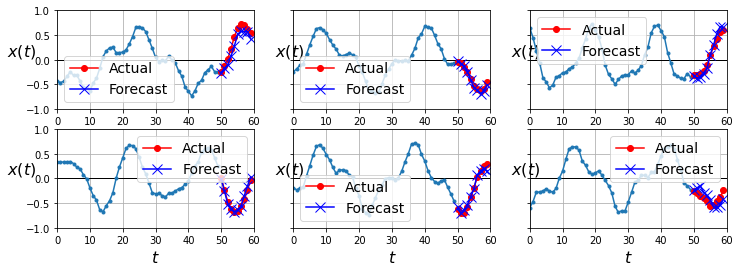

In [ ]:
ypred = model_lstm_dense.predict(X_valid)


fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 4))

for idx, (r,c) in enumerate([(r,c) for r in range(2) for c in range(3)]):
    plt.sca(axes[r,c])
    plot_multiple_forecasts(np.expand_dims(X_valid[idx], 0), 
                            np.expand_dims(Y_valid[idx, None], -1),
                            np.expand_dims(ypred[idx, None], -1))
plt.show()

### GRU + Dense 

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model_gru_dense = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=False),
    keras.layers.Dense(10)
    #keras.layers.TimeDistributed(keras.layers.Dense(10))
], name='gru_dense')

model_gru_dense.compile(loss="mse", optimizer="adam")
history = model_gru_dense.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 18s 61ms/step - loss: 0.0687 - val_loss: 0.0420
Epoch 2/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0388 - val_loss: 0.0352
Epoch 3/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0328 - val_loss: 0.0303
Epoch 4/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0290 - val_loss: 0.0266
Epoch 5/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0239 - val_loss: 0.0206
Epoch 6/20
219/219 [==============================] - 13s 58ms/step - loss: 0.0164 - val_loss: 0.0139
Epoch 7/20
219/219 [==============================] - 13s 57ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 8/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 9/20
219/219 [==============================] - 13s 59ms/step - loss: 0.0106 - val_loss: 0.0100
Epoch 10/20
219/219 [==============================] - 13s 58ms/step - loss: 0.010

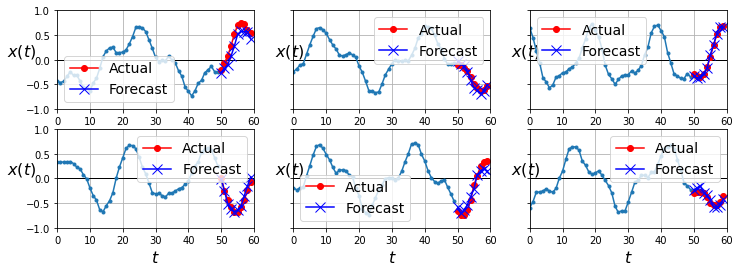

In [ ]:
ypred2 = model_gru_dense.predict(X_valid)

fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 4))

for idx, (r,c) in enumerate([(r,c) for r in range(2) for c in range(3)]):
    plt.sca(axes[r,c])
    plot_multiple_forecasts(np.expand_dims(X_valid[idx], 0), 
                            np.expand_dims(Y_valid[idx, None], -1),
                            np.expand_dims(ypred2[idx, None], -1))
plt.show()

# Compare models 

In [ ]:
all_models = [model_deep_rnn_dense, model_lstm_dense, model_gru_dense]
losses = {mm.name:mm.evaluate(X_test, Y_test) for mm in all_models}

32/32 [==============================] - 0s 11ms/step - loss: 0.0083


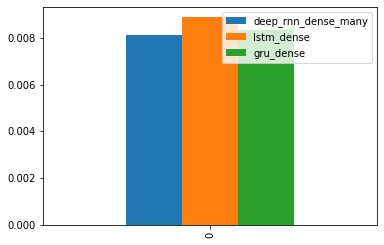

In [ ]:
pd.DataFrame(losses, index=[0]).plot(kind='bar')

# Multivariate forecasting 

We can extend above models by making the units in the last dense layer equal to `nsteps * nfeatures` and then reshaping the outputs. 

```python

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

```